# Create customised kernel to be used with drift detectors

### Sometimes we might prefer to use some prior knowledge or pre-trained embeddings to build a customised kernel (distance) function instead. In this notebook, we will demonstrate how to implement a user-defined kernel with either a customised distance function or a specific feature projection function. 

In [1]:
import numpy as np
import scipy.stats as stats
import torch
import matplotlib.pyplot as plt
import tensorflow as tf

backend = 'pytorch'

from alibi_detect.cd import MMDDrift
if backend == 'pytorch':
    from alibi_detect.utils.pytorch.kernels import BaseKernel, ProjKernel, GaussianRBF
elif backend == 'tensorflow':
    from alibi_detect.utils.tensorflow.kernels import BaseKernel, ProjKernel, GaussianRBF
else:
    raise ValueError('Backend {} not supported'.format(backend))

import matplotlib.pyplot as plt
%matplotlib inline

### We first consider to create a kernel that uses a user specified distance function. For instance, we can write a periodic kernel's distance function with the Trigonometric functions: $k(x,y) = exp(-2 \cdot \frac{sin(pi \cdot \frac{|x - y|}{\tau})^2}{\sigma^2})$. To do so, the easiest way is to import and inherit the BaseKernel class from the corresponding backend (here we use Pytorch), and overload the kernelfunction method.

### For this example, we manually specified the kernel's parameters in the kernel function. To implement these parameters as variables for training or initialisation heuristics, please refer to the implementations in the built-in kernels.

In [2]:
class PeriodicKernel(BaseKernel):
    def __init__(self) -> None:
        super().__init__()

    def kernel_function(self, x, y):
        tau = 24.0 # period parameter
        sigma = 0.05 # bandwidth parameter
        x, y = torch.as_tensor(x), torch.as_tensor(y)
        x2 = x.pow(2).sum(dim=-1, keepdim=True)
        y2 = y.pow(2).sum(dim=-1, keepdim=True)
        dist = torch.addmm(y2.transpose(-2, -1), x, y.transpose(-2, -1), alpha=-2).add_(x2)
        kernel_mat = torch.exp(-2 * torch.square(torch.sin(torch.as_tensor(np.pi) * dist / tau)) / (sigma ** 2))
        return kernel_mat

### Now we create a toy dataset to test our new kernel, where the test data shows an apparent drift around the wave through.

In [3]:
def get_sin(N):
    c_0 = np.random.uniform(0, 168, N)
    x_0 = np.sin(c_0 / (12 / np.pi)) + np.random.normal(0, 0.1, N)

    c_1 = stats.beta.rvs(a=1.2, b=1.2, size=N) * 24 + np.random.choice([0, 24, 48, 72, 96, 120, 144], size=N)
    x_1 = np.sin(c_1 / (12 / np.pi)) * (np.mod(c_1, 24) < 12) + \
        np.sin(c_1 / (12 / np.pi)) * (np.mod(c_1, 24) >= 12) * 1.25 + \
            + np.random.normal(0, 0.1, N)
        
    x_ref = np.hstack([c_0.reshape(-1, 1), x_0.reshape(-1, 1)])
    x_test = np.hstack([c_1.reshape(-1, 1), x_1.reshape(-1, 1)])    
        
    return x_ref, x_test

In [4]:
x_ref, x_test = get_sin(N=1000)

(-1.5, 1.5)

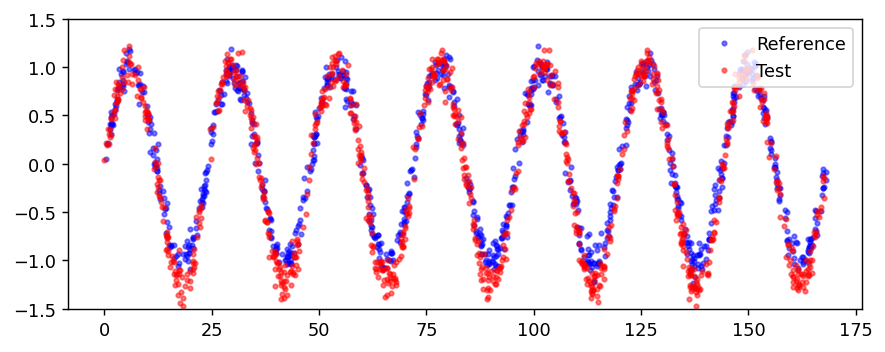

In [5]:
plt.figure(figsize=(8, 3), dpi=128)
plt.plot(x_ref[:, 0], x_ref[:, 1], 'bo', alpha=0.5, markersize=2.5, label='Reference')
plt.plot(x_test[:, 0], x_test[:, 1], 'ro', alpha=0.5, markersize=2.5, label='Test')
plt.legend()
plt.ylim(-1.5, 1.5)

### We can now create an instance of the periodic kernel implemented above and use it with the MMD detector. 

In [17]:
kernel_period = PeriodicKernel()

cd = MMDDrift(x_ref=x_ref,
              backend=backend,
              kernel=kernel_period)

No GPU detected, fall back on CPU.


In [18]:
preds = cd.predict(x_test)
preds

{'data': {'is_drift': 1,
  'distance': 0.0006290622733601328,
  'p_val': 0.029999999329447746,
  'threshold': 0.05,
  'distance_threshold': array(0.00055086, dtype=float32)},
 'meta': {'name': 'MMDDriftTorch',
  'detector_type': 'offline',
  'data_type': None,
  'version': '0.9.2dev',
  'backend': 'pytorch'}}

### Alternatively, we might consider using a projection function (which could be anything from a straightforward linear transform to a deep net) to imply our knowledge about the dataset. In this case, we can consider implementing the kernel with the ProjKernel class, where we can define the projection function using the model class from the corresponding backend (i.e. torch.nn.Module).

In [13]:
class MyProj(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()

    def forward(self, x):
        x = torch.as_tensor(x)
        return torch.cat([torch.remainder(x[:, 0], 24).reshape(-1, 1), x[:, 1].reshape(-1, 1)], axis=1)

### As indicated by the code above, here we create a simple projection function by getting the remainder of the first feature after dividing by 24, while the second feature is kept.

(-1.5, 1.5)

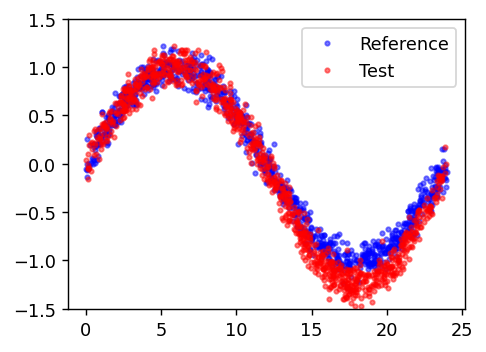

In [19]:
proj = MyProj()

x_proj_ref = proj(x_ref)

x_proj_test = proj(x_test)

plt.figure(figsize=(4, 3), dpi=128)
plt.plot(x_proj_ref[:, 0], x_proj_ref[:, 1], 'bo', alpha=0.5, markersize=2.5, label='Reference')
plt.plot(x_proj_test[:, 0], x_proj_test[:, 1], 'ro', alpha=0.5, markersize=2.5, label='Test')
plt.legend()
plt.ylim(-1.5, 1.5)

### We can then create the kernel with the projection model and a base RBF kernel and use it together with the MMD detector. 

In [25]:
kernel_proj = ProjKernel(proj = proj,
                         raw_kernel= GaussianRBF(sigma=torch.as_tensor(0.05)))

cd_proj = MMDDrift(x_ref=x_ref,
                   backend=backend,
                   kernel=kernel_proj)


No GPU detected, fall back on CPU.


In [26]:
preds_proj = cd_proj.predict(x_test)
preds_proj

{'data': {'is_drift': 1,
  'distance': 0.0009441937452792366,
  'p_val': 0.0,
  'threshold': 0.05,
  'distance_threshold': array(0.00010083, dtype=float32)},
 'meta': {'name': 'MMDDriftTorch',
  'detector_type': 'offline',
  'data_type': None,
  'version': '0.9.2dev',
  'backend': 'pytorch'}}